# DAY 46

## 一、 什么是注意力

之前复试班强化部分的transformer框架那节课已经介绍过注意力机制的由来，本质从onehot-elmo-selfattention-encoder-bert这就是一条不断提取特征的路。各有各的特点，也可以说由弱到强。

其中注意力机制是一种让模型学会「选择性关注重要信息」的特征提取器，就像人类视觉会自动忽略背景，聚焦于图片中的主体（如猫、汽车）。
transformer中的叫做自注意力机制，他是一种自己学习自己的机制，他可以自动学习到图片中的主体，并忽略背景。我们现在说的很多模块，比如通道注意力、空间注意力、通道注意力等等，都是基于自注意力机制的。

从数学角度看，注意力机制是对输入特征进行加权求和，输出=∑(输入特征×注意力权重)，其中注意力权重是学习到的。所以他和卷积很像，因为卷积也是一种加权求和。但是卷积是 “固定权重” 的特征提取（如 3x3 卷积核）--训练完了就结束了，注意力是 “动态权重” 的特征提取（权重随输入数据变化）---输入数据不同权重不同。

问：为什么需要多种注意力模块？
答：因为不同场景下的关键信息分布不同。例如，识别鸟类和飞机时，需关注 “羽毛纹理”“金属光泽” 等特定通道的特征，通道注意力可强化关键通道；而物体位置不确定时（如猫出现在图像不同位置），空间注意力能聚焦物体所在区域，忽略背景。复杂场景中，可能需要同时关注通道和空间（如混合注意力模块 CBAM），或处理长距离依赖（如全局注意力模块 Non-local）。

问：为什么不设计一个‘万能’注意力模块？
答：主要受效率和灵活性限制。专用模块针对特定需求优化计算，成本更低（如通道注意力仅需处理通道维度，无需全局位置计算）；不同任务的核心需求差异大（如医学图像侧重空间定位，自然语言处理侧重语义长距离依赖），通用模块可能冗余或低效。每个模块新增的权重会增加模型参数量，若训练数据不足或优化不当，可能引发过拟合。因此实际应用中需结合轻量化设计（如减少全连接层参数）、正则化（如 Dropout）或结构约束（如共享注意力权重）来平衡性能与复杂度。


通道注意力（Channel Attention）属于**注意力机制（Attention Mechanism）的变体**，而非自注意力（Self-Attention）的直接变体。可以理解为注意力是一个动物园算法，里面很多个物种，自注意力只是一个分支，因为开创了transformer所以备受瞩目。我们今天的内容用通道注意力举例


常见注意力模块的归类如下
| 注意力模块         | 所属类别               | 核心功能                                                                 |
|---------------------|------------------------|--------------------------------------------------------------------------|
| 自注意力（Self-Attention） | 自注意力变体           | 建模同一输入内部元素的依赖（如序列位置、图像块）                       |
| 通道注意力（Channel Attention） | 普通注意力变体（全局上下文） | 建模特征图通道间的重要性，通过全局池化压缩空间信息                     |
| 空间注意力（Spatial Attention） | 普通注意力变体（全局上下文） | 建模特征图空间位置的重要性，关注“哪里”更重要                           |
| 多头注意力（Multi-Head Attention） | 自注意力/普通注意力的增强版 | 将query/key/value投影到多个子空间，捕捉多维度依赖                       |
| 编码器-解码器注意力（Encoder-Decoder Attention） | 普通注意力变体         | 建模编码器输出与解码器输入的跨模态交互（如机器翻译中句子与译文的对齐）   |


## 二、 特征图的提取

### 2.1 简单CNN的训练

昨天我已经介绍了cnn，为了好演示，我就重新训练了之前的cnn代码，你可以直接加载之前保存好的权重试试，一般重新训练1-2轮就会恢复效果。

使用设备: cuda
Files already downloaded and verified
开始使用CNN训练模型...
Epoch: 1/50 | Batch: 100/782 | 单Batch损失: 1.8418 | 累计平均损失: 2.0633
Epoch: 1/50 | Batch: 200/782 | 单Batch损失: 1.7869 | 累计平均损失: 1.9262
Epoch: 1/50 | Batch: 300/782 | 单Batch损失: 1.6917 | 累计平均损失: 1.8580
Epoch: 1/50 | Batch: 400/782 | 单Batch损失: 1.5382 | 累计平均损失: 1.8069
Epoch: 1/50 | Batch: 500/782 | 单Batch损失: 1.6528 | 累计平均损失: 1.7666
Epoch: 1/50 | Batch: 600/782 | 单Batch损失: 1.6119 | 累计平均损失: 1.7309
Epoch: 1/50 | Batch: 700/782 | 单Batch损失: 1.4111 | 累计平均损失: 1.7027
Epoch 1/50 完成 | 训练准确率: 37.96% | 测试准确率: 54.66%
Epoch: 2/50 | Batch: 100/782 | 单Batch损失: 1.5224 | 累计平均损失: 1.4354
Epoch: 2/50 | Batch: 200/782 | 单Batch损失: 1.2684 | 累计平均损失: 1.3797
Epoch: 2/50 | Batch: 300/782 | 单Batch损失: 1.1981 | 累计平均损失: 1.3445
Epoch: 2/50 | Batch: 400/782 | 单Batch损失: 1.0925 | 累计平均损失: 1.3228
Epoch: 2/50 | Batch: 500/782 | 单Batch损失: 1.1819 | 累计平均损失: 1.3026
Epoch: 2/50 | Batch: 600/782 | 单Batch损失: 1.0772 | 累计平均损失: 1.2862
Epoch: 2/50 | Batch: 700/782 | 单Batch损失: 1.11

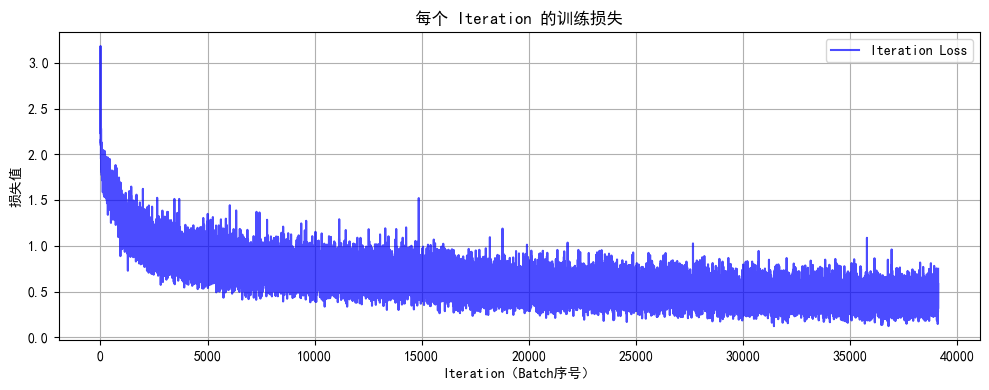

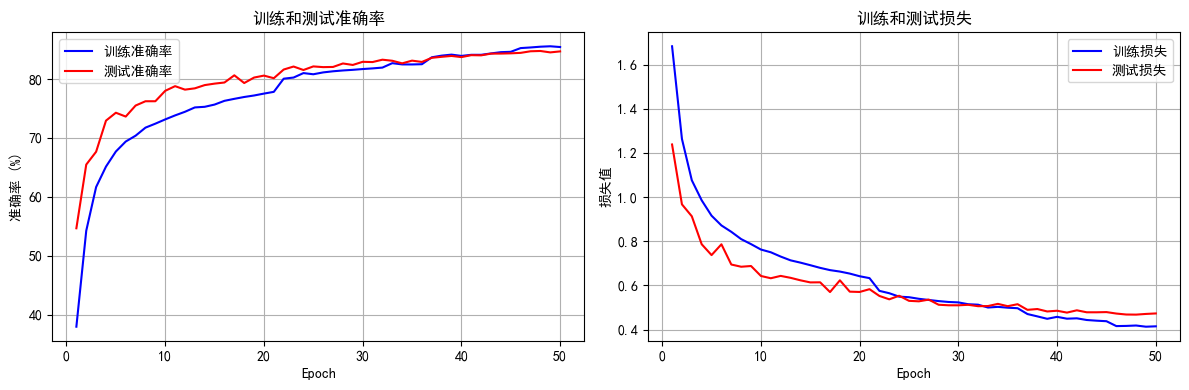

训练完成！最终测试准确率: 84.68%


In [39]:

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# 设置中文字体支持
plt.rcParams["font.family"] = ["SimHei"]
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 检查GPU是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# 1. 数据预处理
# 训练集：使用多种数据增强方法提高模型泛化能力
train_transform = transforms.Compose([
    # 随机裁剪图像，从原图中随机截取32x32大小的区域
    transforms.RandomCrop(32, padding=4),
    # 随机水平翻转图像（概率0.5）
    transforms.RandomHorizontalFlip(),
    # 随机颜色抖动：亮度、对比度、饱和度和色调随机变化
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    # 随机旋转图像（最大角度15度）
    transforms.RandomRotation(15),
    # 将PIL图像或numpy数组转换为张量
    transforms.ToTensor(),
    # 标准化处理：每个通道的均值和标准差，使数据分布更合理
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# 测试集：仅进行必要的标准化，保持数据原始特性，标准化不损失数据信息，可还原
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# 2. 加载CIFAR-10数据集
train_dataset = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=train_transform  # 使用增强后的预处理
)

test_dataset = datasets.CIFAR10(
    root='./data',
    train=False,
    transform=test_transform  # 测试集不使用增强
)

# 3. 创建数据加载器
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# 4. 定义CNN模型的定义（替代原MLP）
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()  # 继承父类初始化
        
        # ---------------------- 第一个卷积块 ----------------------
        # 卷积层1：输入3通道（RGB），输出32个特征图，卷积核3x3，边缘填充1像素
        self.conv1 = nn.Conv2d(
            in_channels=3,       # 输入通道数（图像的RGB通道）
            out_channels=32,     # 输出通道数（生成32个新特征图）
            kernel_size=3,       # 卷积核尺寸（3x3像素）
            padding=1            # 边缘填充1像素，保持输出尺寸与输入相同
        )
        # 批量归一化层：对32个输出通道进行归一化，加速训练
        self.bn1 = nn.BatchNorm2d(num_features=32)
        # ReLU激活函数：引入非线性，公式：max(0, x)
        self.relu1 = nn.ReLU()
        # 最大池化层：窗口2x2，步长2，特征图尺寸减半（32x32→16x16）
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # stride默认等于kernel_size
        
        # ---------------------- 第二个卷积块 ----------------------
        # 卷积层2：输入32通道（来自conv1的输出），输出64通道
        self.conv2 = nn.Conv2d(
            in_channels=32,      # 输入通道数（前一层的输出通道数）
            out_channels=64,     # 输出通道数（特征图数量翻倍）
            kernel_size=3,       # 卷积核尺寸不变
            padding=1            # 保持尺寸：16x16→16x16（卷积后）→8x8（池化后）
        )
        self.bn2 = nn.BatchNorm2d(num_features=64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)  # 尺寸减半：16x16→8x8
        
        # ---------------------- 第三个卷积块 ----------------------
        # 卷积层3：输入64通道，输出128通道
        self.conv3 = nn.Conv2d(
            in_channels=64,      # 输入通道数（前一层的输出通道数）
            out_channels=128,    # 输出通道数（特征图数量再次翻倍）
            kernel_size=3,
            padding=1            # 保持尺寸：8x8→8x8（卷积后）→4x4（池化后）
        )
        self.bn3 = nn.BatchNorm2d(num_features=128)
        self.relu3 = nn.ReLU()  # 复用激活函数对象（节省内存）
        self.pool3 = nn.MaxPool2d(kernel_size=2)  # 尺寸减半：8x8→4x4
        
        # ---------------------- 全连接层（分类器） ----------------------
        # 计算展平后的特征维度：128通道 × 4x4尺寸 = 128×16=2048维
        self.fc1 = nn.Linear(
            in_features=128 * 4 * 4,  # 输入维度（卷积层输出的特征数）
            out_features=512          # 输出维度（隐藏层神经元数）
        )
        # Dropout层：训练时随机丢弃50%神经元，防止过拟合
        self.dropout = nn.Dropout(p=0.5)
        # 输出层：将512维特征映射到10个类别（CIFAR-10的类别数）
        self.fc2 = nn.Linear(in_features=512, out_features=10)

    def forward(self, x):
        # 输入尺寸：[batch_size, 3, 32, 32]（batch_size=批量大小，3=通道数，32x32=图像尺寸）
        
        # ---------- 卷积块1处理 ----------
        x = self.conv1(x)       # 卷积后尺寸：[batch_size, 32, 32, 32]（padding=1保持尺寸）
        x = self.bn1(x)         # 批量归一化，不改变尺寸
        x = self.relu1(x)       # 激活函数，不改变尺寸
        x = self.pool1(x)       # 池化后尺寸：[batch_size, 32, 16, 16]（32→16是因为池化窗口2x2）
        
        # ---------- 卷积块2处理 ----------
        x = self.conv2(x)       # 卷积后尺寸：[batch_size, 64, 16, 16]（padding=1保持尺寸）
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)       # 池化后尺寸：[batch_size, 64, 8, 8]
        
        # ---------- 卷积块3处理 ----------
        x = self.conv3(x)       # 卷积后尺寸：[batch_size, 128, 8, 8]（padding=1保持尺寸）
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)       # 池化后尺寸：[batch_size, 128, 4, 4]
        
        # ---------- 展平与全连接层 ----------
        # 将多维特征图展平为一维向量：[batch_size, 128*4*4] = [batch_size, 2048]
        x = x.view(-1, 128 * 4 * 4)  # -1自动计算批量维度，保持批量大小不变
        
        x = self.fc1(x)           # 全连接层：2048→512，尺寸变为[batch_size, 512]
        x = self.relu3(x)         # 激活函数（复用relu3，与卷积块3共用）
        x = self.dropout(x)       # Dropout随机丢弃神经元，不改变尺寸
        x = self.fc2(x)           # 全连接层：512→10，尺寸变为[batch_size, 10]（未激活，直接输出logits）
        
        return x  # 输出未经过Softmax的logits，适用于交叉熵损失函数



# 初始化模型
model = CNN()
model = model.to(device)  # 将模型移至GPU（如果可用）

criterion = nn.CrossEntropyLoss()  # 交叉熵损失函数
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam优化器

# 引入学习率调度器，在训练过程中动态调整学习率--训练初期使用较大的 LR 快速降低损失，训练后期使用较小的 LR 更精细地逼近全局最优解。
# 在每个 epoch 结束后，需要手动调用调度器来更新学习率，可以在训练过程中调用 scheduler.step()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,        # 指定要控制的优化器（这里是Adam）
    mode='min',       # 监测的指标是"最小化"（如损失函数）
    patience=3,       # 如果连续3个epoch指标没有改善，才降低LR
    factor=0.5        # 降低LR的比例（新LR = 旧LR × 0.5）
)
# 5. 训练模型（记录每个 iteration 的损失）
def train(model, train_loader, test_loader, criterion, optimizer, scheduler, device, epochs):
    model.train()  # 设置为训练模式
    
    # 记录每个 iteration 的损失
    all_iter_losses = []  # 存储所有 batch 的损失
    iter_indices = []     # 存储 iteration 序号
    
    # 记录每个 epoch 的准确率和损失
    train_acc_history = []
    test_acc_history = []
    train_loss_history = []
    test_loss_history = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)  # 移至GPU
            
            optimizer.zero_grad()  # 梯度清零
            output = model(data)  # 前向传播
            loss = criterion(output, target)  # 计算损失
            loss.backward()  # 反向传播
            optimizer.step()  # 更新参数
            
            # 记录当前 iteration 的损失
            iter_loss = loss.item()
            all_iter_losses.append(iter_loss)
            iter_indices.append(epoch * len(train_loader) + batch_idx + 1)
            
            # 统计准确率和损失
            running_loss += iter_loss
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
            
            # 每100个批次打印一次训练信息
            if (batch_idx + 1) % 100 == 0:
                print(f'Epoch: {epoch+1}/{epochs} | Batch: {batch_idx+1}/{len(train_loader)} '
                      f'| 单Batch损失: {iter_loss:.4f} | 累计平均损失: {running_loss/(batch_idx+1):.4f}')
        
        # 计算当前epoch的平均训练损失和准确率
        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = 100. * correct / total
        train_acc_history.append(epoch_train_acc)
        train_loss_history.append(epoch_train_loss)
        
        # 测试阶段
        model.eval()  # 设置为评估模式
        test_loss = 0
        correct_test = 0
        total_test = 0
        
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += criterion(output, target).item()
                _, predicted = output.max(1)
                total_test += target.size(0)
                correct_test += predicted.eq(target).sum().item()
        
        epoch_test_loss = test_loss / len(test_loader)
        epoch_test_acc = 100. * correct_test / total_test
        test_acc_history.append(epoch_test_acc)
        test_loss_history.append(epoch_test_loss)
        
        # 更新学习率调度器
        scheduler.step(epoch_test_loss)
        
        print(f'Epoch {epoch+1}/{epochs} 完成 | 训练准确率: {epoch_train_acc:.2f}% | 测试准确率: {epoch_test_acc:.2f}%')
    
    # 绘制所有 iteration 的损失曲线
    plot_iter_losses(all_iter_losses, iter_indices)
    
    # 绘制每个 epoch 的准确率和损失曲线
    plot_epoch_metrics(train_acc_history, test_acc_history, train_loss_history, test_loss_history)
    
    return epoch_test_acc  # 返回最终测试准确率

# 6. 绘制每个 iteration 的损失曲线
def plot_iter_losses(losses, indices):
    plt.figure(figsize=(10, 4))
    plt.plot(indices, losses, 'b-', alpha=0.7, label='Iteration Loss')
    plt.xlabel('Iteration（Batch序号）')
    plt.ylabel('损失值')
    plt.title('每个 Iteration 的训练损失')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 7. 绘制每个 epoch 的准确率和损失曲线
def plot_epoch_metrics(train_acc, test_acc, train_loss, test_loss):
    epochs = range(1, len(train_acc) + 1)
    
    plt.figure(figsize=(12, 4))
    
    # 绘制准确率曲线
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, 'b-', label='训练准确率')
    plt.plot(epochs, test_acc, 'r-', label='测试准确率')
    plt.xlabel('Epoch')
    plt.ylabel('准确率 (%)')
    plt.title('训练和测试准确率')
    plt.legend()
    plt.grid(True)
    
    # 绘制损失曲线
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, 'b-', label='训练损失')
    plt.plot(epochs, test_loss, 'r-', label='测试损失')
    plt.xlabel('Epoch')
    plt.ylabel('损失值')
    plt.title('训练和测试损失')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# 8. 执行训练和测试
epochs = 50  # 增加训练轮次为了确保收敛
print("开始使用CNN训练模型...")
final_accuracy = train(model, train_loader, test_loader, criterion, optimizer, scheduler, device, epochs)
print(f"训练完成！最终测试准确率: {final_accuracy:.2f}%")

# # 保存模型
# torch.save(model.state_dict(), 'cifar10_cnn_model.pth')
# print("模型已保存为: cifar10_cnn_model.pth")

可以看到测试集一定程度上收敛了，在85%左右（还可以继续训练的），我们后续和加了通道注意力的该模型作对比，这也意味着我们进入到了消融实验的部分了。

- 过去我们都是在同一个数据集上对比不同的模型的差异，或者同一个模型不同参数下的差异，这种实验叫做对比实验。

- 在同一个数据集上，对同一个模型进行模块的增加和减少，这种实验我们称之为消融实验。通过消融实验，研究者能更清晰地理解模型各部分的作用，而对比实验则用于评估模型的整体竞争力。两者常结合使用，以全面验证模型设计的合理性。

### 2.2 特征图可视化

为了方便观察，我们先尝试提取下特征图。特征图本质就是不同的卷积核的输出，浅层指的是离输入图近的卷积层，浅层卷积层的特征图通常较大，而深层特征图会经过多次下采样，尺寸显著缩小，尺寸差异过大时，小尺寸特征图在视觉上会显得模糊或丢失细节。步骤逻辑如下：


1. **初始化设置**：
   - 将模型设为评估模式，准备类别名称列表（如飞机、汽车等）。

2. **数据加载与处理**：
   - 从测试数据加载器中获取图像和标签。
   - 仅处理前 `num_images` 张图像（如2张）。

3. **注册钩子捕获特征图**：
   - 为指定层（如 `conv1`, `conv2`, `conv3`）注册前向钩子。
   - 钩子函数将这些层的输出（特征图）保存到字典中。

4. **前向传播与特征提取**：
   - 模型处理图像，触发钩子函数，获取并保存特征图。
   - 移除钩子，避免后续干扰。

5. **可视化特征图**：
   - 对每张图像：
     - 恢复原始像素值并显示。
     - 为每个目标层创建子图，展示前 `num_channels` 个通道的特征图（如9个通道）。
     - 每个通道的特征图以网格形式排列，显示通道编号。


**关键细节**
- **特征图布局**：原始图像在左侧，各层特征图按顺序排列在右侧。
- **通道选择**：默认显示前9个通道（按重要性或索引排序）。
- **显示优化**：
  - 使用 `inset_axes` 在大图中嵌入小网格，清晰展示每个通道。
  - 层标题与通道标题分开，避免重叠。
  - 反标准化处理恢复图像原始色彩。




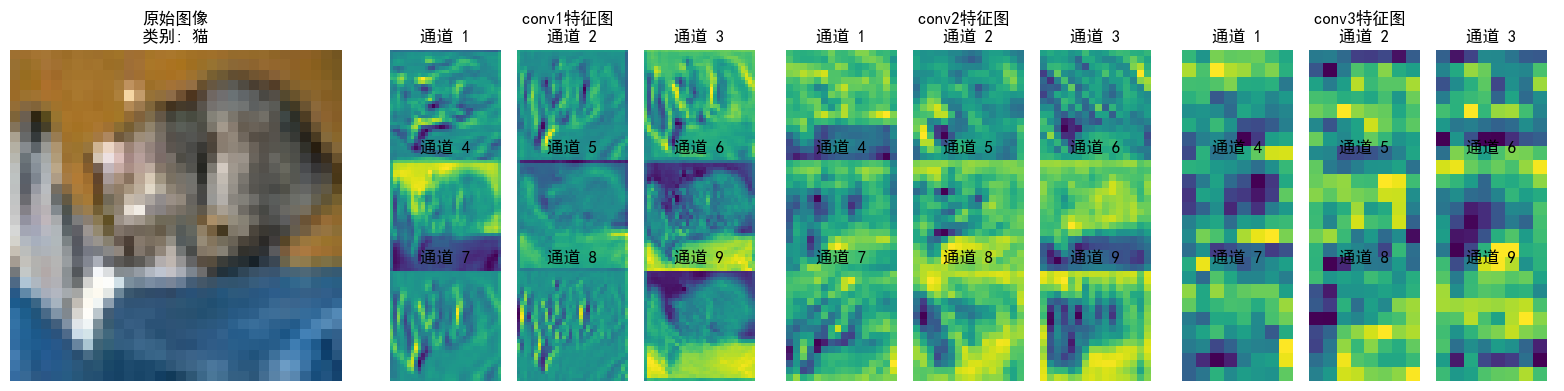

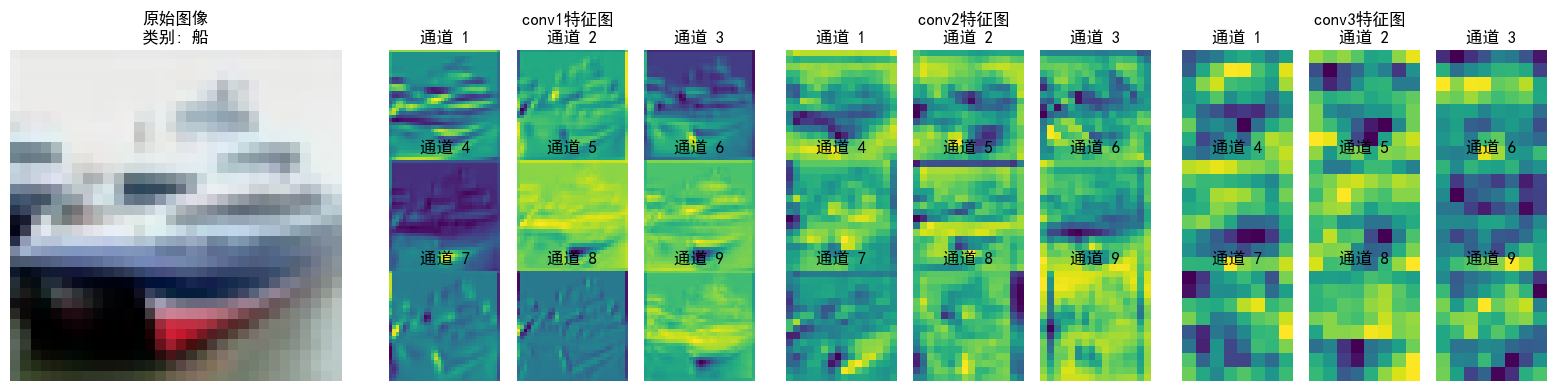

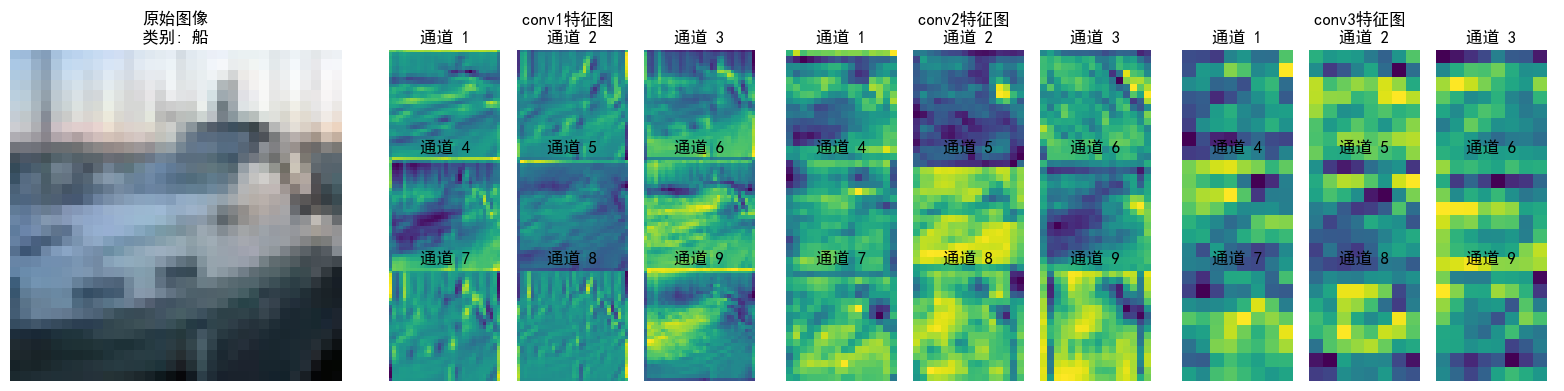

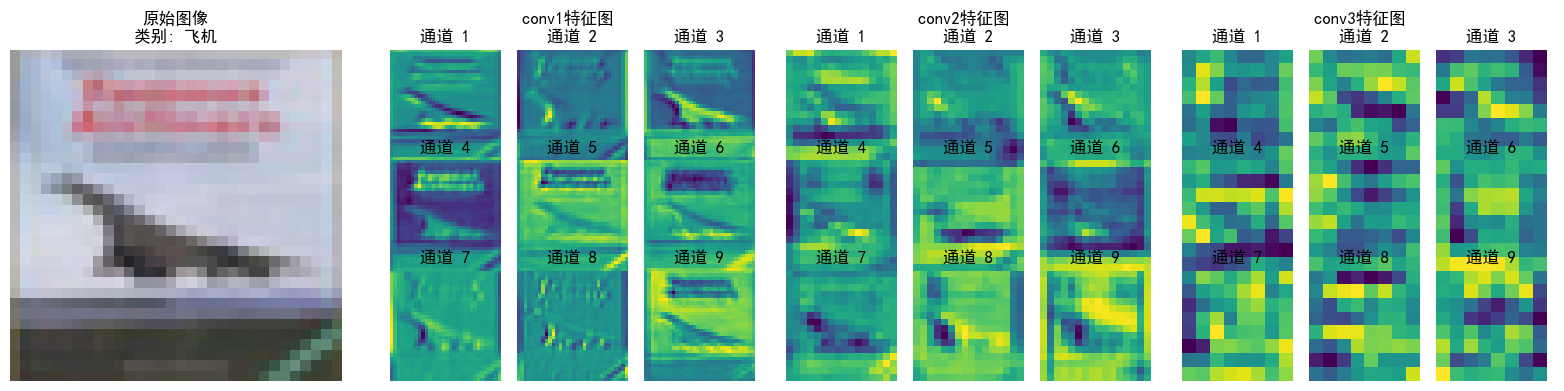

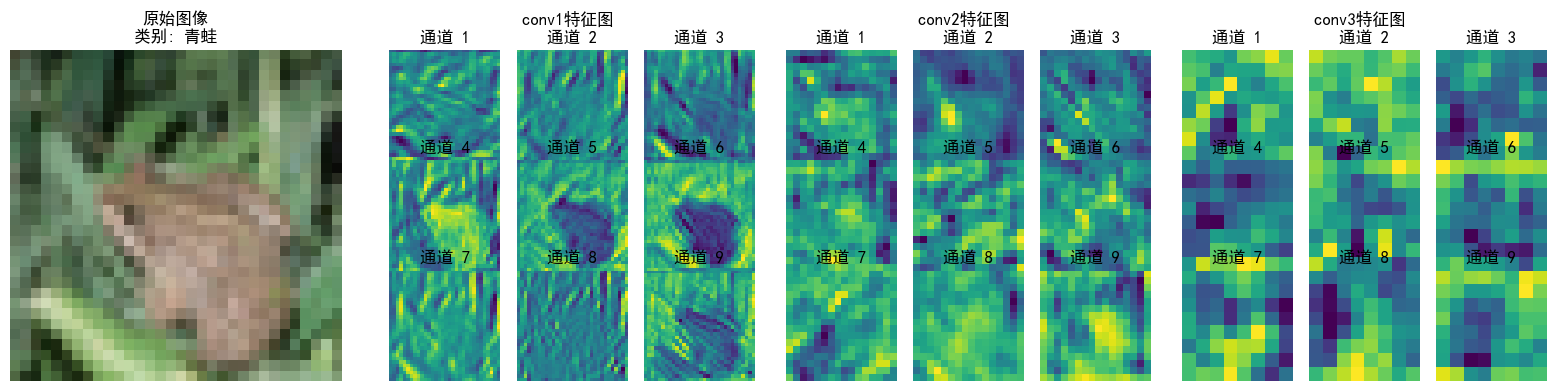

In [40]:
def visualize_feature_maps(model, test_loader, device, layer_names, num_images=3, num_channels=9):
    """
    可视化指定层的特征图（修复循环冗余问题）
    参数:
        model: 模型
        test_loader: 测试数据加载器
        layer_names: 要可视化的层名称（如['conv1', 'conv2', 'conv3']）
        num_images: 可视化的图像总数
        num_channels: 每个图像显示的通道数（取前num_channels个通道）
    """
    model.eval()  # 设置为评估模式
    class_names = ['飞机', '汽车', '鸟', '猫', '鹿', '狗', '青蛙', '马', '船', '卡车']
    
    # 从测试集加载器中提取指定数量的图像（避免嵌套循环）
    images_list, labels_list = [], []
    for images, labels in test_loader:
        images_list.append(images)
        labels_list.append(labels)
        if len(images_list) * test_loader.batch_size >= num_images:
            break
    # 拼接并截取到目标数量
    images = torch.cat(images_list, dim=0)[:num_images].to(device)
    labels = torch.cat(labels_list, dim=0)[:num_images].to(device)

    with torch.no_grad():
        # 存储各层特征图
        feature_maps = {}
        # 保存钩子句柄
        hooks = []
        
        # 定义钩子函数，捕获指定层的输出
        def hook(module, input, output, name):
            feature_maps[name] = output.cpu()  # 保存特征图到字典
        
        # 为每个目标层注册钩子，并保存钩子句柄
        for name in layer_names:
            module = getattr(model, name)
            hook_handle = module.register_forward_hook(lambda m, i, o, n=name: hook(m, i, o, n))
            hooks.append(hook_handle)
        
        # 前向传播触发钩子
        _ = model(images)
        
        # 正确移除钩子
        for hook_handle in hooks:
            hook_handle.remove()
        
        # 可视化每个图像的各层特征图（仅一层循环）
        for img_idx in range(num_images):
            img = images[img_idx].cpu().permute(1, 2, 0).numpy()
            # 反标准化处理（恢复原始像素值）
            img = img * np.array([0.2023, 0.1994, 0.2010]).reshape(1, 1, 3) + np.array([0.4914, 0.4822, 0.4465]).reshape(1, 1, 3)
            img = np.clip(img, 0, 1)  # 确保像素值在[0,1]范围内
            
            # 创建子图
            num_layers = len(layer_names)
            fig, axes = plt.subplots(1, num_layers + 1, figsize=(4 * (num_layers + 1), 4))
            
            # 显示原始图像
            axes[0].imshow(img)
            axes[0].set_title(f'原始图像\n类别: {class_names[labels[img_idx]]}')
            axes[0].axis('off')
            
            # 显示各层特征图
            for layer_idx, layer_name in enumerate(layer_names):
                fm = feature_maps[layer_name][img_idx]  # 取第img_idx张图像的特征图
                fm = fm[:num_channels]  # 仅取前num_channels个通道
                num_rows = int(np.sqrt(num_channels))
                num_cols = num_channels // num_rows if num_rows != 0 else 1
                
                # 创建子图网格
                layer_ax = axes[layer_idx + 1]
                layer_ax.set_title(f'{layer_name}特征图 \n')# 加个换行让文字分离上去
                layer_ax.axis('off')  # 关闭大子图的坐标轴
                
                # 在大子图内创建小网格
                for ch_idx, channel in enumerate(fm):
                    ax = layer_ax.inset_axes([ch_idx % num_cols / num_cols, 
                                            (num_rows - 1 - ch_idx // num_cols) / num_rows, 
                                            1/num_cols, 1/num_rows])
                    ax.imshow(channel.numpy(), cmap='viridis')
                    ax.set_title(f'通道 {ch_idx + 1}')
                    ax.axis('off')
            
            plt.tight_layout()
            plt.show()

# 调用示例（按需修改参数）
layer_names = ['conv1', 'conv2', 'conv3']
visualize_feature_maps(
    model=model,
    test_loader=test_loader,
    device=device,
    layer_names=layer_names,
    num_images=5,  # 可视化5张测试图像 → 输出5张大图
    num_channels=9   # 每张图像显示前9个通道的特征图
)

上面的图为提取CNN不同卷积层输出的特征图，我们以第五张图片-青蛙 进行解读。

由于经过了不断的下采样，特征变得越来越抽象，人类已经无法理解。

 **核心作用**
通过可视化特征图，可直观观察：
- 浅层卷积层（如 `conv1`）如何捕获边缘、纹理等低级特征。
- 深层卷积层（如 `conv3`）如何组合低级特征形成语义概念（如物体部件）。
- 模型对不同类别的关注区域差异（如鸟类的羽毛纹理 vs. 飞机的金属光泽）。



conv1 特征图（浅层卷积）
- **特点**：
  - 保留较多原始图像的**细节纹理**（如植物叶片、青蛙身体的边缘轮廓）。
  - 通道间差异相对小，每个通道都能看到类似原始图像的基础结构（如通道 1 - 9 都能识别边缘、纹理）。
- **意义**：
  - 提取**低级特征**（边缘、颜色块、简单纹理），是后续高层特征的“原材料”。
  - 类似人眼初步识别图像的轮廓和基础结构。

conv2 特征图（中层卷积）
- **特点**：
  - 空间尺寸（高、宽）比 conv1 更小（因卷积/池化下采样），但**语义信息更抽象**。
  - 通道间差异更明显：部分通道开始聚焦**局部关键特征**（如通道 5、8 中黄色高亮区域，可能对应青蛙身体或植物的关键纹理）。
- **意义**：
  - 对 conv1 的低级特征进行**组合与筛选**，提取**中级特征**（如局部形状、纹理组合）。
  - 类似人眼从“边缘轮廓”过渡到“识别局部结构”（如青蛙的身体块、植物的叶片簇）。

 conv3 特征图（深层卷积）
- **特点**：
  - 空间尺寸进一步缩小，**抽象程度最高**，肉眼难直接对应原始图像细节。
  - 通道间差异极大，部分通道聚焦**全局语义特征**（如通道 4、7 中黄色区域，可能对应模型判断“青蛙”类别的关键特征）。
- **意义**：
  - 对 conv2 的中级特征进行**全局整合**，提取**高级语义特征**（如物体类别相关的抽象模式）。
  - 类似人眼最终“识别出这是青蛙”的关键依据，模型通过这些特征判断类别。

逐层对比总结
| 层级    | 特征图特点                     | 对应模型能力                     | 类比人类视觉流程               |
|---------|------------------------------|----------------------------------|--------------------------------|
| 原始图像 | 细节丰富但无抽象语义           | 无（纯输入）                     | 视网膜接收原始光信号           |
| conv1   | 保留基础细节，提取低级特征     | 识别边缘、纹理                   | 视觉皮层初步解析轮廓           |
| conv2   | 抽象化，提取局部关键特征       | 识别局部结构（如身体块、叶片簇） | 大脑进一步组合特征识别局部模式 |
| conv3   | 高度抽象，聚焦全局语义特征     | 识别类别相关核心模式             | 大脑最终整合信息判断“这是青蛙” |


- **特征逐层抽象**：从“看得见的细节”（conv1）→ “局部结构”（conv2）→ “类别相关的抽象模式”（conv3），模型通过这种方式实现从“看图像”到“理解语义”的跨越。
- **通道分工明确**：不同通道在各层聚焦不同特征（如有的通道负责边缘，有的负责颜色，有的负责全局语义），共同协作完成分类任务。
- **下采样的作用**：通过缩小空间尺寸，换取更高的语义抽象能力（“牺牲细节，换取理解”）。


## 三、通道注意力

现在我们引入通道注意力，来观察精度是否有变化，并且进一步可视化。

想要把通道注意力插入到模型中，关键步骤如下：

1. 定义注意力模块
2. 重写之前的模型定义部分，确定好模块插入的位置


### 3.1 通道注意力的定义

In [41]:
# ===================== 新增：通道注意力模块（SE模块） =====================
class ChannelAttention(nn.Module):
    """通道注意力模块(Squeeze-and-Excitation)"""
    def __init__(self, in_channels, reduction_ratio=16):
        """
        参数:
            in_channels: 输入特征图的通道数
            reduction_ratio: 降维比例，用于减少参数量
        """
        super(ChannelAttention, self).__init__()
        
        # 全局平均池化 - 将空间维度压缩为1x1，保留通道信息
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        
        # 全连接层 + 激活函数，用于学习通道间的依赖关系
        self.fc = nn.Sequential(
            # 降维：压缩通道数，减少计算量
            nn.Linear(in_channels, in_channels // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            # 升维：恢复原始通道数
            nn.Linear(in_channels // reduction_ratio, in_channels, bias=False),
            # Sigmoid将输出值归一化到[0,1]，表示通道重要性权重
            nn.Sigmoid()
        )

    def forward(self, x):
        """
        参数:
            x: 输入特征图，形状为 [batch_size, channels, height, width]
        
        返回:
            加权后的特征图，形状不变
        """
        batch_size, channels, height, width = x.size()
        
        # 1. 全局平均池化：[batch_size, channels, height, width] → [batch_size, channels, 1, 1]
        avg_pool_output = self.avg_pool(x)
        
        # 2. 展平为一维向量：[batch_size, channels, 1, 1] → [batch_size, channels]
        avg_pool_output = avg_pool_output.view(batch_size, channels)
        
        # 3. 通过全连接层学习通道权重：[batch_size, channels] → [batch_size, channels]
        channel_weights = self.fc(avg_pool_output)
        
        # 4. 重塑为二维张量：[batch_size, channels] → [batch_size, channels, 1, 1]
        channel_weights = channel_weights.view(batch_size, channels, 1, 1)
        
        # 5. 将权重应用到原始特征图上（逐通道相乘）
        return x * channel_weights  # 输出形状：[batch_size, channels, height, width]

通道注意力模块的核心原理
1. Squeeze（压缩）：
- 通过全局平均池化将每个通道的二维特征图（H×W）压缩为一个标量，保留通道的全局信息。
- 物理意义：计算每个通道在整个图像中的 “平均响应强度”，例如，“边缘检测通道” 在有物体边缘的图像中响应值会更高。
2. Excitation（激发）：
- 通过全连接层 + Sigmoid 激活，学习通道间的依赖关系，输出 0-1 之间的权重值。
- 物理意义：让模型自动判断哪些通道更重要（权重接近 1），哪些通道可忽略（权重接近 0）。
3. Reweight（重加权）：
- 将学习到的通道权重与原始特征图逐通道相乘，增强重要通道，抑制不重要通道。
- 物理意义：类似人类视觉系统聚焦于关键特征（如猫的轮廓），忽略无关特征（如背景颜色）

通道注意力插入后，参数量略微提高，增加了特征提取能力

### 3.2 模型的重新定义（通道注意力的插入）

In [42]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()  
        
        # ---------------------- 第一个卷积块 ----------------------
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        # 新增：插入通道注意力模块（SE模块）
        self.ca1 = ChannelAttention(in_channels=32, reduction_ratio=16)  
        self.pool1 = nn.MaxPool2d(2, 2)  
        
        # ---------------------- 第二个卷积块 ----------------------
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        # 新增：插入通道注意力模块（SE模块）
        self.ca2 = ChannelAttention(in_channels=64, reduction_ratio=16)  
        self.pool2 = nn.MaxPool2d(2)  
        
        # ---------------------- 第三个卷积块 ----------------------
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        # 新增：插入通道注意力模块（SE模块）
        self.ca3 = ChannelAttention(in_channels=128, reduction_ratio=16)  
        self.pool3 = nn.MaxPool2d(2)  
        
        # ---------------------- 全连接层（分类器） ----------------------
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        # ---------- 卷积块1处理 ----------
        x = self.conv1(x)       
        x = self.bn1(x)         
        x = self.relu1(x)       
        x = self.ca1(x)  # 应用通道注意力
        x = self.pool1(x)       
        
        # ---------- 卷积块2处理 ----------
        x = self.conv2(x)       
        x = self.bn2(x)         
        x = self.relu2(x)       
        x = self.ca2(x)  # 应用通道注意力
        x = self.pool2(x)       
        
        # ---------- 卷积块3处理 ----------
        x = self.conv3(x)       
        x = self.bn3(x)         
        x = self.relu3(x)       
        x = self.ca3(x)  # 应用通道注意力
        x = self.pool3(x)       
        
        # ---------- 展平与全连接层 ----------
        x = x.view(-1, 128 * 4 * 4)  
        x = self.fc1(x)           
        x = self.relu3(x)         
        x = self.dropout(x)       
        x = self.fc2(x)           
        
        return x  

# 重新初始化模型，包含通道注意力模块
model = CNN()
model = model.to(device)  # 将模型移至GPU（如果可用）

criterion = nn.CrossEntropyLoss()  # 交叉熵损失函数
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam优化器

# 引入学习率调度器，在训练过程中动态调整学习率--训练初期使用较大的 LR 快速降低损失，训练后期使用较小的 LR 更精细地逼近全局最优解。
# 在每个 epoch 结束后，需要手动调用调度器来更新学习率，可以在训练过程中调用 scheduler.step()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,        # 指定要控制的优化器（这里是Adam）
    mode='min',       # 监测的指标是"最小化"（如损失函数）
    patience=3,       # 如果连续3个epoch指标没有改善，才降低LR
    factor=0.5        # 降低LR的比例（新LR = 旧LR × 0.5）
)

开始训练带通道注意力的CNN模型...
Epoch: 1/50 | Batch: 100/782 | 单Batch损失: 1.8910 | 累计平均损失: 1.9942
Epoch: 1/50 | Batch: 200/782 | 单Batch损失: 1.6923 | 累计平均损失: 1.8823
Epoch: 1/50 | Batch: 300/782 | 单Batch损失: 1.6001 | 累计平均损失: 1.8048
Epoch: 1/50 | Batch: 400/782 | 单Batch损失: 1.2822 | 累计平均损失: 1.7508
Epoch: 1/50 | Batch: 500/782 | 单Batch损失: 1.5353 | 累计平均损失: 1.7110
Epoch: 1/50 | Batch: 600/782 | 单Batch损失: 1.4252 | 累计平均损失: 1.6772
Epoch: 1/50 | Batch: 700/782 | 单Batch损失: 1.5700 | 累计平均损失: 1.6480
Epoch 1/50 完成 | 训练准确率: 40.15% | 测试准确率: 54.47%
Epoch: 2/50 | Batch: 100/782 | 单Batch损失: 1.1785 | 累计平均损失: 1.3923
Epoch: 2/50 | Batch: 200/782 | 单Batch损失: 1.1950 | 累计平均损失: 1.3703
Epoch: 2/50 | Batch: 300/782 | 单Batch损失: 1.5047 | 累计平均损失: 1.3450
Epoch: 2/50 | Batch: 400/782 | 单Batch损失: 0.9452 | 累计平均损失: 1.3163
Epoch: 2/50 | Batch: 500/782 | 单Batch损失: 1.4187 | 累计平均损失: 1.2955
Epoch: 2/50 | Batch: 600/782 | 单Batch损失: 1.2744 | 累计平均损失: 1.2757
Epoch: 2/50 | Batch: 700/782 | 单Batch损失: 0.8026 | 累计平均损失: 1.2576
Epoch 2/50 完成 | 训练准确率: 5

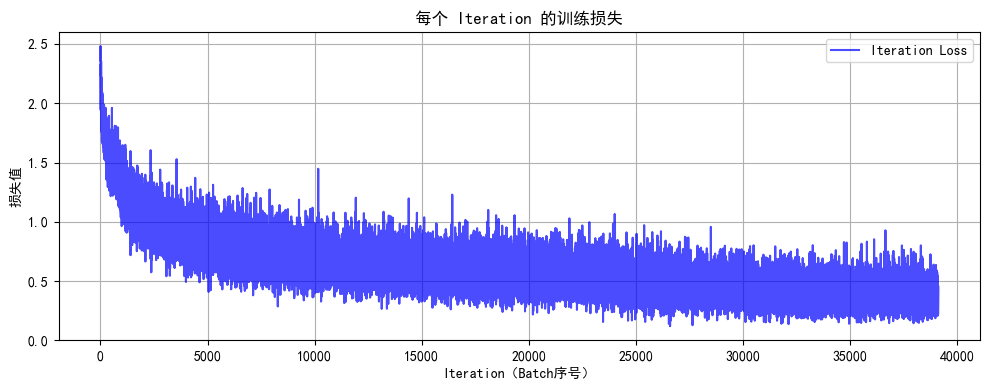

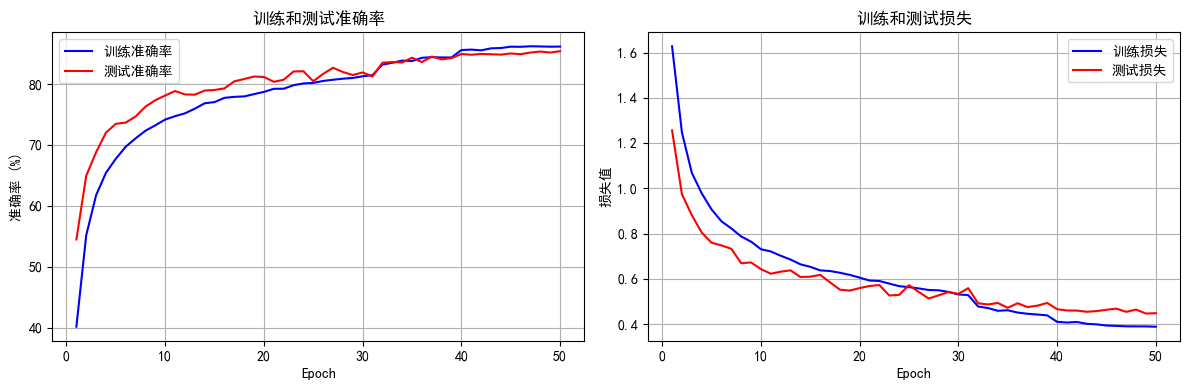

训练完成！最终测试准确率: 85.38%


In [43]:
# 训练模型（复用原有的train函数）
print("开始训练带通道注意力的CNN模型...")
final_accuracy = train(model, train_loader, test_loader, criterion, optimizer, scheduler, device, epochs=50)
print(f"训练完成！最终测试准确率: {final_accuracy:.2f}%")

在同样50个epoch后精度略有提升

我们关注的不只是精度的差异，还包含了同精度下训练时长的差异等，在大规模数据集上推理时长、训练时长都非常重要。因为资源是有限的。

可视化部分同理，在训练完成后通过钩子函数取出权重or梯度，即可进行特征图的可视化、Grad-CAM可视化、注意力热图可视化

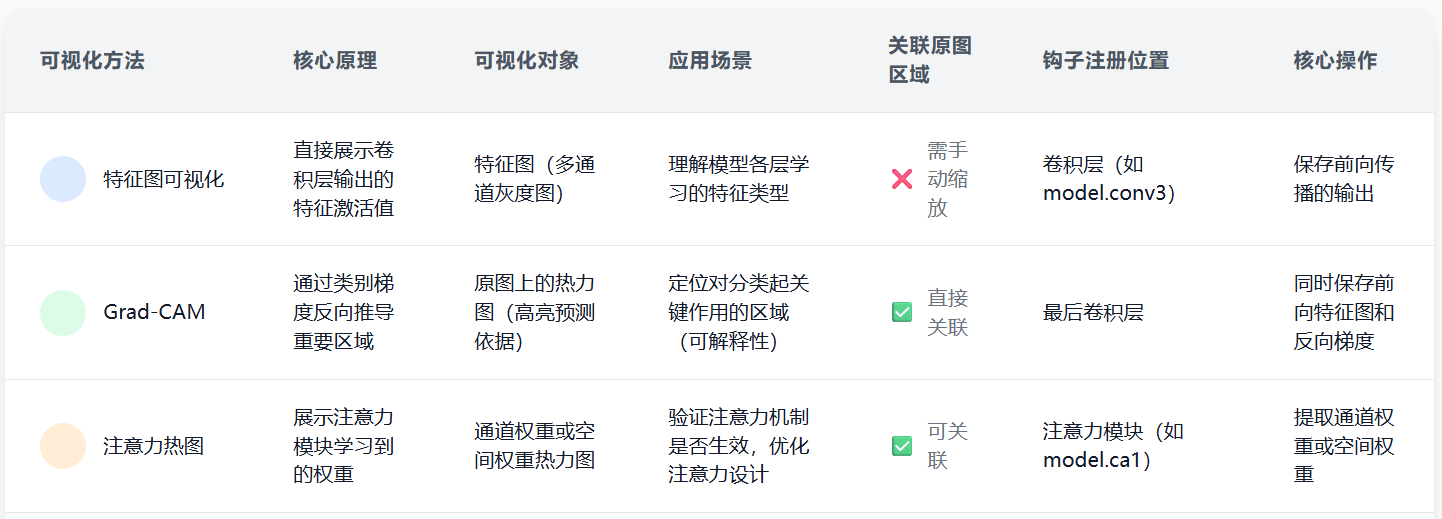

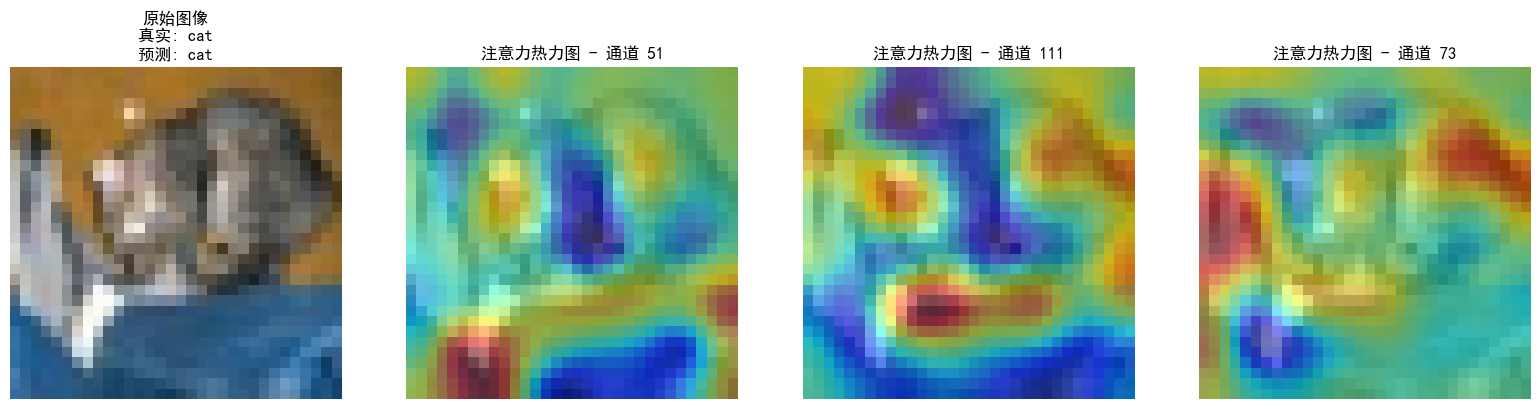

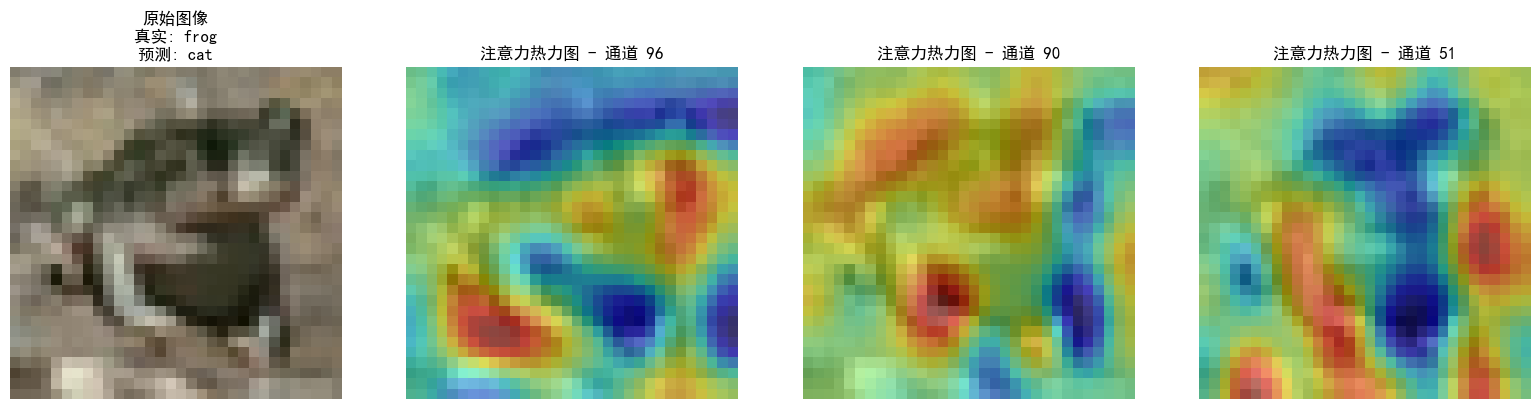

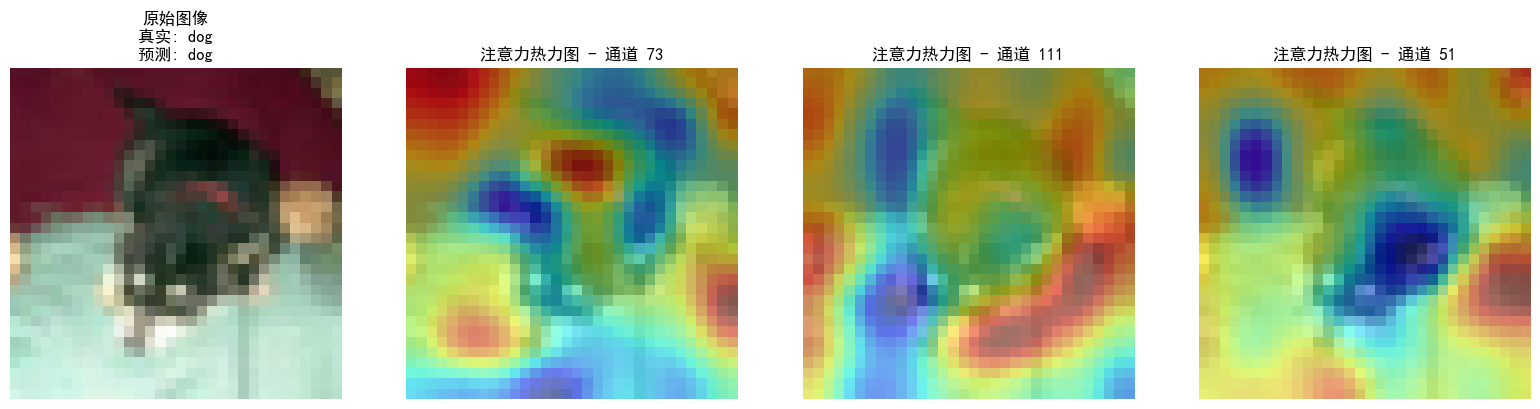

In [44]:
# 可视化空间注意力热力图（显示模型关注的图像区域）
def visualize_attention_map(model, test_loader, device, class_names, num_samples=3):
    """可视化模型的注意力热力图，展示模型关注的图像区域"""
    model.eval()  # 设置为评估模式
    
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            if i >= num_samples:  # 只可视化前几个样本
                break
                
            images, labels = images.to(device), labels.to(device)
            
            # 创建一个钩子，捕获中间特征图
            activation_maps = []
            
            def hook(module, input, output):
                activation_maps.append(output.cpu())
            
            # 为最后一个卷积层注册钩子（获取特征图）
            hook_handle = model.conv3.register_forward_hook(hook)
            
            # 前向传播，触发钩子
            outputs = model(images)
            
            # 移除钩子
            hook_handle.remove()
            
            # 获取预测结果
            _, predicted = torch.max(outputs, 1)
            
            # 获取原始图像
            img = images[0].cpu().permute(1, 2, 0).numpy()
            # 反标准化处理
            img = img * np.array([0.2023, 0.1994, 0.2010]).reshape(1, 1, 3) + np.array([0.4914, 0.4822, 0.4465]).reshape(1, 1, 3)
            img = np.clip(img, 0, 1)
            
            # 获取激活图（最后一个卷积层的输出）
            feature_map = activation_maps[0][0].cpu()  # 取第一个样本
            
            # 计算通道注意力权重（使用SE模块的全局平均池化）
            channel_weights = torch.mean(feature_map, dim=(1, 2))  # [C]
            
            # 按权重对通道排序
            sorted_indices = torch.argsort(channel_weights, descending=True)
            
            # 创建子图
            fig, axes = plt.subplots(1, 4, figsize=(16, 4))
            
            # 显示原始图像
            axes[0].imshow(img)
            axes[0].set_title(f'原始图像\n真实: {class_names[labels[0]]}\n预测: {class_names[predicted[0]]}')
            axes[0].axis('off')
            
            # 显示前3个最活跃通道的热力图
            for j in range(3):
                channel_idx = sorted_indices[j]
                # 获取对应通道的特征图
                channel_map = feature_map[channel_idx].numpy()
                # 归一化到[0,1]
                channel_map = (channel_map - channel_map.min()) / (channel_map.max() - channel_map.min() + 1e-8)
                
                # 调整热力图大小以匹配原始图像
                from scipy.ndimage import zoom
                heatmap = zoom(channel_map, (32/feature_map.shape[1], 32/feature_map.shape[2]))
                
                # 显示热力图
                axes[j+1].imshow(img)
                axes[j+1].imshow(heatmap, alpha=0.5, cmap='jet')
                axes[j+1].set_title(f'注意力热力图 - 通道 {channel_idx}')
                axes[j+1].axis('off')
            
            plt.tight_layout()
            plt.show()

# 调用可视化函数
visualize_attention_map(model, test_loader, device, class_names, num_samples=3)

这个注意力热图是通过构子机制： `register_forward_hook` 捕获最后一个卷积层（`conv3`）的输出特征图。  
  1. **通道权重计算**：对特征图的每个通道进行全局平均池化，得到通道重要性权重。  
  2. **热力图生成**：将高权重通道的特征图缩放至原始图像尺寸，与原图叠加显示。


热力图（红色表示高关注，蓝色表示低关注）半透明覆盖在原图上。主要从以下方面理解：

- **高关注区域**（红色）：模型认为对分类最重要的区域。  
  例如：  
  - 在识别“狗”时，热力图可能聚焦狗的面部、身体轮廓或特征性纹理。  
  - 若热力图错误聚焦背景（如红色区域在无关物体上），可能表示模型过拟合或训练不足。

**多通道对比**
- **不同通道关注不同特征**：  
  例如：  
  - 通道1可能关注整体轮廓，通道2关注纹理细节，通道3关注颜色分布。  
  - 结合多个通道的热力图，可全面理解模型的决策逻辑。

可以帮助解释
   - 检查模型是否关注正确区域（如识别狗时，是否聚焦狗而非背景）。  
   - 发现数据标注问题（如标签错误、图像噪声）。
   - 向非技术人员解释模型决策依据（如“模型认为这是狗，因为关注了眼睛和嘴巴”）。
